In [29]:
import stumpy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import os
import sys
import logging

logging.basicConfig(level=logging.INFO)

In [30]:
current = os.path.dirname(os.path.realpath(sys.argv[0]))
parent = os.path.dirname(current)
sys.path.append(parent)

from MSig import Motif, NullModel

In [31]:
#read the data
colnames = ['datetime', "sum_terminals", "sum_roaming_terminals", "sum_phonecalls"]
data = pd.read_csv("../data/populationdensity/hourly_saodomingosbenfica.csv", usecols=colnames, parse_dates=['datetime'])
data = data.set_index('datetime').sort_index()
data.columns = ['Terminals', 'Roaming Terminals', 'Phone Calls']
data

,Terminals,Roaming Terminals,Phone Calls
datetime,,,
2021-09-15 00:00:00,228256.0,3838.0,1788.0
2021-09-15 01:00:00,236425.0,3701.0,1102.0
2021-09-15 02:00:00,223600.0,3377.0,598.0
2021-09-15 03:00:00,194192.0,2637.0,285.0
2021-09-15 04:00:00,261136.0,3287.0,182.0
...,...,...,...
2021-11-30 19:00:00,316390.0,4018.0,16637.0
2021-11-30 20:00:00,351831.0,4491.0,18158.0
2021-11-30 21:00:00,311190.0,4149.0,13265.0


In [32]:
X = data.to_numpy().astype(np.float64).T
X

array([[228256., 236425., 223600., ..., 311190., 323163., 314228.],
       [  3838.,   3701.,   3377., ...,   4149.,   4253.,   4218.],
       [  1788.,   1102.,    598., ...,  13265.,  12492.,  11377.]])

In [33]:
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 2 # r = np.ceil(m/2)
include = None
normalize = True
subsequence_lengths = [6, 12, 24, 48]

In [34]:
for m in subsequence_lengths:
    mp, mp_indices = stumpy.mstump(X, m, include=include, normalize=normalize)
    np.save('../results/populationdensity/mp/mp_normalized={}_include={}_m={}.npy'.format(normalize,include,m), mp)
    np.save('../results/populationdensity/mp_indices/mp_indices_normalized={}_include={}_m={}.npy'.format(normalize,include,m), mp_indices)

In [35]:
def table_summary_motifs(motif_indices, motif_distances, motif_subspaces, data, m, normalize, max_allowed_dist):
    mp_stats_table = pd.DataFrame(columns=["ID", "k", "Features", "m", "#Matches", "Indices", "max(dists)", "min(dists)", "med(dists)"])

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]
    
    model_empirical = NullModel(data, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):

        dimensions = motif_subspaces[motif_indice]
            
        #remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        #if is empty, skip
        if len(match_indices) == 0:
            continue
        
        #remove trivial matches  
        non_trivial_matches = []
        for indice in match_indices:
           trivial = False
           for indice_new in non_trivial_matches:
               if abs(indice - indice_new) <= m/2:
                   trivial = True
                   break
           if not trivial:
               non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        #  N = np.floor((n-p)/r) + 1
        r = np.ceil(m/2)
        max_possible_matches = int(np.floor((n_time-m)/r) + 1)



        #get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][:,match_indices[0]:match_indices[0]+m]
    
        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])
        avg_dist = np.mean(match_distances[1:])
        std_dist = np.std(match_distances[1:])
        med_dist = np.median(match_distances[1:])
        
        #D is distance profile between the motif pattern and Time serie
        if max_allowed_dist is None:
            D = np.empty((n_time-m+1, len(dimensions)))
            for i, dimension in enumerate(dimensions):
                D[:,i] = stumpy.mass(multivar_subsequence[i], data[dimension], normalize=normalize)
            D = np.mean(D, axis=1)
            max_allowed_dist = np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
            

        #data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        #max_delta = max_allowed_dist        # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(max_allowed_dist**2/m)  # avg dist per element = SQRT((dist^2)/n_length)
        delta_thresholds = [max_delta]*len(data)

        
        #########SIG#########
        motif = Motif(multivar_subsequence, dimensions, delta_thresholds, len(match_indices))
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(max_possible_matches, n_vars, idd_correction=False) 

        stats_df = {"ID": str(motif_index), "k":len(dimensions),
                    "Features":",".join(used_features),
                        "m":m,
                    "#Matches": len(match_indices)-1,
                        "Indices":match_indices,
                        "max(dists)": np.around(max_dist,3), "min(dists)": np.around(min_dist,3),
                        "med(dists)": np.around(med_dist,3),  "P": p, "p-value": pvalue}
    
        mp_stats_table = pd.concat(
            [mp_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
        
        motif_index += 1
    return mp_stats_table

In [36]:
k = None
min_neighbors = 1
cutoffs = np.inf
max_matches = 99999
average_delta = 0.3
max_dists = []
max_motifs = 99999
mp_stats_table = pd.DataFrame()
for m in subsequence_lengths:
    max_distance = math.sqrt(m)*average_delta
    max_dists.append(max_distance)

    excl_zone = int(np.ceil(m/2))

    mp= np.load('../results/populationdensity/mp/mp_normalized={}_include={}_m={}.npy'.format(normalize,include,m))
    mp_indices = np.load('../results/populationdensity/mp_indices/mp_indices_normalized={}_include={}_m={}.npy'.format(normalize,include,m))
    motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.mmotifs(X, mp, mp_indices, max_distance=max_distance,max_matches=max_matches,
                                                                                 cutoffs=cutoffs, min_neighbors=min_neighbors, max_motifs=max_motifs, k=k, include=include, normalize=normalize)

    if len(motif_indices[0]) == 0:
        continue
    print("m:{}, #Motifs:{}".format(m, len(motif_indices)))  
    table = table_summary_motifs(motif_indices, motif_distances, motif_subspaces, X, m, normalize, max_distance)
    print("Sig ", np.sum(table["p-value"] < 0.01))

    #hochberg procedure
    p_values = table["p-value"].to_numpy()
    critical_value =  NullModel.hochberg_critical_value(p_values, 0.05)
    sig = table["p-value"] < critical_value if critical_value != 0 else table["p-value"] <= critical_value
    table["Sig_Hochber"] = sig

    print("Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value))


    mp_stats_table = pd.concat([mp_stats_table, table], ignore_index=True)

mp_stats_table.to_csv('../results/populationdensity/table_motifs_min_neighbors={}_max_distance={}_cutoffs={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_dists, cutoffs, max_matches, max_motifs), index=False)

m:6, #Motifs:52


INFO:root:p_value = 5.303E-104 (p_pattern = 3.929E-09)
INFO:root:p_value = 8.936E-80 (p_pattern = 5.206E-03)
INFO:root:p_value = 3.498E-281 (p_pattern = 7.962E-06)
INFO:root:p_value = 1.104E-01 (p_pattern = 1.875E-03)
INFO:root:p_value = 1.144E-22 (p_pattern = 1.114E-05)
INFO:root:p_value = 6.251E-56 (p_pattern = 7.038E-03)
INFO:root:p_value = 6.589E-43 (p_pattern = 3.035E-02)
INFO:root:p_value = 2.430E-17 (p_pattern = 1.539E-02)
INFO:root:p_value = 8.760E-69 (p_pattern = 1.716E-05)
INFO:root:p_value = 9.997E-77 (p_pattern = 1.777E-03)
INFO:root:p_value = 8.305E-74 (p_pattern = 5.490E-03)
INFO:root:p_value = 3.492E-185 (p_pattern = 3.840E-04)
INFO:root:p_value = 9.118E-210 (p_pattern = 3.077E-04)
INFO:root:p_value = 2.986E-46 (p_pattern = 8.113E-03)
INFO:root:p_value = 7.546E-21 (p_pattern = 6.325E-04)
INFO:root:p_value = 2.348E-01 (p_pattern = 2.715E-03)
INFO:root:p_value = 3.530E-103 (p_pattern = 1.012E-04)
INFO:root:p_value = 6.569E-51 (p_pattern = 1.657E-03)
INFO:root:p_value = 1.0

Sig  38
Sig after Hochberg: 39, critical value: 0.033099583712792625


INFO:root:p_value = 6.075E-12 (p_pattern = 1.138E-05)


m:12, #Motifs:27


INFO:root:p_value = 3.225E-310 (p_pattern = 1.893E-11)
INFO:root:p_value = 8.332E-279 (p_pattern = 4.811E-06)
INFO:root:p_value = 1.627E-186 (p_pattern = 1.266E-04)
INFO:root:p_value = 1.812E-44 (p_pattern = 1.560E-17)
INFO:root:p_value = 4.369E-149 (p_pattern = 4.516E-05)
INFO:root:p_value = 2.281E-104 (p_pattern = 1.922E-08)
INFO:root:p_value = 1.227E-188 (p_pattern = 9.889E-06)
INFO:root:p_value = 1.051E-160 (p_pattern = 1.377E-08)
INFO:root:p_value = 5.140E-18 (p_pattern = 1.950E-03)
INFO:root:p_value = 1.876E-180 (p_pattern = 5.023E-07)
INFO:root:p_value = 3.028E-02 (p_pattern = 8.769E-04)
INFO:root:p_value = 6.628E-59 (p_pattern = 8.357E-08)
INFO:root:p_value = 4.143E-39 (p_pattern = 6.277E-03)
INFO:root:p_value = 3.071E-42 (p_pattern = 2.353E-04)
INFO:root:p_value = 2.475E-07 (p_pattern = 2.296E-06)
INFO:root:p_value = 2.018E-61 (p_pattern = 6.458E-06)
INFO:root:p_value = 2.135E-65 (p_pattern = 7.159E-08)
INFO:root:p_value = 5.155E-10 (p_pattern = 1.323E-03)
INFO:root:p_value = 

Sig  26
Sig after Hochberg: 26, critical value: 0.030278767884366318


INFO:root:p_value = 8.920E-41 (p_pattern = 4.205E-09)
INFO:root:p_value = 6.703E-07 (p_pattern = 7.595E-06)


m:24, #Motifs:35


INFO:root:p_value = 6.378E-19 (p_pattern = 1.029E-08)
INFO:root:p_value = 2.356E-56 (p_pattern = 2.028E-06)
INFO:root:p_value = 1.398E-117 (p_pattern = 3.957E-11)
INFO:root:p_value = 1.662E-134 (p_pattern = 1.934E-09)
INFO:root:p_value = 7.179E-20 (p_pattern = 2.485E-12)
INFO:root:p_value = 2.795E-85 (p_pattern = 1.121E-11)
INFO:root:p_value = 4.259E-100 (p_pattern = 8.756E-10)
INFO:root:p_value = 2.140E-79 (p_pattern = 9.920E-08)
INFO:root:p_value = 2.724E-38 (p_pattern = 3.597E-15)
INFO:root:p_value = 4.624E-20 (p_pattern = 1.994E-12)
INFO:root:p_value = 1.662E-36 (p_pattern = 2.165E-08)
INFO:root:p_value = 4.489E-16 (p_pattern = 1.965E-10)
INFO:root:p_value = 1.200E-16 (p_pattern = 5.897E-08)
INFO:root:p_value = 2.021E-36 (p_pattern = 1.318E-20)
INFO:root:p_value = 1.530E-22 (p_pattern = 5.139E-08)
INFO:root:p_value = 5.524E-96 (p_pattern = 9.090E-12)
INFO:root:p_value = 1.032E-12 (p_pattern = 9.420E-09)
INFO:root:p_value = 1.667E-23 (p_pattern = 2.952E-08)
INFO:root:p_value = 1.735

Sig  34
Sig after Hochberg: 34, critical value: 0.010247241768613727


INFO:root:p_value = 4.830E-40 (p_pattern = 1.901E-15)
INFO:root:p_value = 2.237E-59 (p_pattern = 6.827E-22)
INFO:root:p_value = 9.958E-30 (p_pattern = 5.911E-17)
INFO:root:p_value = 6.547E-47 (p_pattern = 8.452E-14)


m:48, #Motifs:15


INFO:root:p_value = 7.428E-47 (p_pattern = 8.723E-14)
INFO:root:p_value = 1.404E-28 (p_pattern = 2.219E-16)
INFO:root:p_value = 1.786E-39 (p_pattern = 2.940E-15)
INFO:root:p_value = 1.392E-33 (p_pattern = 6.988E-19)
INFO:root:p_value = 1.455E-26 (p_pattern = 2.259E-15)
INFO:root:p_value = 1.131E-35 (p_pattern = 6.299E-20)
INFO:root:p_value = 8.101E-38 (p_pattern = 5.331E-21)
INFO:root:p_value = 4.994E-31 (p_pattern = 1.324E-17)
INFO:root:p_value = 1.782E-27 (p_pattern = 7.907E-16)
INFO:root:p_value = 6.231E-34 (p_pattern = 4.676E-19)
INFO:root:p_value = 1.824E-27 (p_pattern = 8.000E-16)


Sig  15
Sig after Hochberg: 14, critical value: 1.4549766323892829e-26


In [37]:
#create a new table for each motif length with statistics of the motifs
mp_stats_table = pd.read_csv('../results/populationdensity/table_motifs_min_neighbors={}_max_distance={}_cutoffs={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_dists, cutoffs, max_matches, max_motifs))

subsequence_lengths = mp_stats_table["m"].unique()
motif_stats_table = pd.DataFrame(columns=["m", "#motifs" , "avg_n_matches", "avg_n_features",  "median_probability",  "median_pvalue", "#sig_motifs(<0.01)", "significant", "#sig_hochberg"])
for m in subsequence_lengths:
    table = mp_stats_table[mp_stats_table["m"] == m]
    n_motifs = table.shape[0]
    n_sig_motifs_001 = table[table["p-value"] < 0.01].shape[0]
    n_sig_motifs_hochberg = table[table["Sig_Hochber"] == True].shape[0]
    avg_n_matches = round(table["#Matches"].mean(),2), round(table["#Matches"].std(),3)
    avg_n_features = round(table["k"].mean(),2), round(table["k"].std(),3)
    avg_probability = table["P"].median()    
    avg_pvalue = table["p-value"].median()

    stats_df = {"m": m, "#motifs": n_motifs, "#sig_motifs(<0.01)": n_sig_motifs_001, "significant":(n_sig_motifs_001*100)/n_motifs,"#sig_hochberg": n_sig_motifs_hochberg,
                "avg_n_matches": avg_n_matches, "avg_n_features": avg_n_features, "median_probability": avg_probability, "median_pvalue": avg_pvalue}
    motif_stats_table = pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)

motif_stats_table

,m,#motifs,avg_n_matches,avg_n_features,median_probability,median_pvalue,#sig_motifs(<0.01),significant,#sig_hochberg
0,6,52,"(23.79, 28.194)","(1.1, 0.358)",1.889628e-03,3.486760e-07,38,73.076923,39
1,12,27,"(17.48, 19.794)","(1.11, 0.32)",5.807269e-06,4.143164e-39,26,96.296296,26
2,24,35,"(3.91, 4.368)","(1.03, 0.169)",8.756463e-10,4.623714e-20,34,97.142857,34
3,48,15,"(1.47, 0.743)","(1.0, 0.0)",2.219243e-16,6.230800e-34,15,100.000000,14


In [38]:
motif_stats_table_print = motif_stats_table.copy()
motif_stats_table_print["avg_n_matches"] = motif_stats_table["avg_n_matches"].apply(lambda x: "{:.2f} +- {:.2f}".format(x[0], x[1]))
motif_stats_table_print["avg_n_features"] = motif_stats_table["avg_n_features"].apply(lambda x: "{:.2f} +- {:.2f}".format(x[0], x[1]))
motif_stats_table_print["median_probability"] = motif_stats_table["median_probability"].apply(lambda x: "{:.2e}".format(x))
motif_stats_table_print["median_pvalue"] = motif_stats_table["median_pvalue"].apply(lambda x: "{:.2e}".format(x))
print(motif_stats_table_print.to_latex(index=False))

\begin{tabular}{lllllllrl}
\toprule
 m & \#motifs &  avg\_n\_matches & avg\_n\_features & median\_probability & median\_pvalue & \#sig\_motifs(<0.01) &  significant & \#sig\_hochberg \\
\midrule
 6 &      52 & 23.79 +- 28.19 &   1.10 +- 0.36 &           1.89e-03 &      3.49e-07 &                 38 &    73.076923 &            39 \\
12 &      27 & 17.48 +- 19.79 &   1.11 +- 0.32 &           5.81e-06 &      4.14e-39 &                 26 &    96.296296 &            26 \\
24 &      35 &   3.91 +- 4.37 &   1.03 +- 0.17 &           8.76e-10 &      4.62e-20 &                 34 &    97.142857 &            34 \\
48 &      15 &   1.47 +- 0.74 &   1.00 +- 0.00 &           2.22e-16 &      6.23e-34 &                 15 &   100.000000 &            14 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_26971/2250515240.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(motif_stats_table_print.to_latex(index=False))


In [39]:
#sort by p-value
mp_stats_table = mp_stats_table.sort_values(by="p-value", ascending=True)
mp_stats_table

,ID,k,Features,m,#Matches,Indices,max(dists),min(dists),med(dists),P,p-value,Sig_Hochber
53,1,2,"1,2",12,32,"[1538, 1586, 1562, 314, 650, 435, 723, 290, 12...",1.034,0.221,0.900,1.893066e-11,3.225302e-310,True
2,2,2,"2,1",6,73,"[522, 1414, 141, 766, 42, 120, 1220, 359, 548,...",0.725,0.079,0.553,7.962253e-06,3.497671e-281,True
54,2,1,2,12,64,"[888, 48, 168, 24, 1656, 120, 1632, 312, 1464,...",1.039,0.133,0.582,4.811276e-06,8.331806e-279,True
12,12,1,2,6,90,"[1723, 713, 1504, 691, 666, 402, 787, 906, 634...",0.733,0.097,0.541,3.076843e-04,9.117994e-210,True
59,7,1,2,12,48,"[1482, 1675, 1626, 1697, 1386, 1650, 882, 281,...",1.038,0.380,0.818,9.889360e-06,1.227315e-188,True
...,...,...,...,...,...,...,...,...,...,...,...,...
44,44,1,1,6,1,"[540, 577]",0.427,0.427,0.427,6.174225e-03,8.931139e-01,False
45,45,1,2,6,1,"[1282, 1377]",0.445,0.445,0.445,1.317839e-02,9.973626e-01,False
47,47,1,1,6,1,"[1162, 347]",0.519,0.519,0.519,2.058253e-02,9.999612e-01,False
20,20,1,1,6,3,"[1619, 1595, 1643, 1046]",0.388,0.172,0.377,3.209266e-02,9.999968e-01,False


In [40]:
#get top 3 most significant for each motif length
for m in subsequence_lengths:
    print("########## m:{} #########".format(m))
    top_3_motifs = mp_stats_table[mp_stats_table["m"] == m].head(3)
    print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
    print("\n\n")

/tmp/ipykernel_26971/2494480790.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))


########## m:6 #########
\begin{tabular}{rrlrrrrrr}
\toprule
 ID &  k & Features &  \#Matches &  max(dists) &  min(dists) &  med(dists) &        P &       p-value \\
\midrule
  2 &  2 &      2,1 &        73 &       0.725 &       0.079 &       0.553 & 0.000008 & 3.497671e-281 \\
 12 &  1 &        2 &        90 &       0.733 &       0.097 &       0.541 & 0.000308 & 9.117994e-210 \\
 11 &  1 &        2 &        84 &       0.732 &       0.088 &       0.436 & 0.000384 & 3.492320e-185 \\
\bottomrule
\end{tabular}




########## m:12 #########
\begin{tabular}{rrlrrrrrr}
\toprule
 ID &  k & Features &  \#Matches &  max(dists) &  min(dists) &  med(dists) &            P &       p-value \\
\midrule
  1 &  2 &      1,2 &        32 &       1.034 &       0.221 &       0.900 & 1.893066e-11 & 3.225302e-310 \\
  2 &  1 &        2 &        64 &       1.039 &       0.133 &       0.582 & 4.811276e-06 & 8.331806e-279 \\
  7 &  1 &        2 &        48 &       1.038 &       0.380 &       0.818 & 9.889360e-0

/tmp/ipykernel_26971/2494480790.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
/tmp/ipykernel_26971/2494480790.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
/tmp/ipykernel_26971

In [41]:
def plot_motif(ts_list, features,  m, motif_indexes, motif_name):

    fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 2*len(ts_list)), squeeze=False)
    for i in range(0,len(ts_list)):
        ts = ts_list[i]
        #plot light grey
        axes[i,1].plot(ts, color='black', linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i,0].set_prop_cycle('color', colors)
        axes[i,1].set_prop_cycle('color', colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index:index+m]
            #original motif in the next plot with the same color
            axes[i,0].plot(subsequence_match.values) 
            # highlight the motif in the original time serie
            axes[i,1].plot(subsequence_match, linewidth=2)
        
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)
        #remove x labels and ticks except from last plot
        if i != len(ts_list)-1:
            axes[i,0].axes.get_xaxis().set_visible(False)
            axes[i,1].axes.get_xaxis().set_visible(False)

        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)

        #format the x axis to show the time and rotate for better reading
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.setp(axes[i,1].xaxis.get_majorticklabels(), rotation=45)
        axes[i,0].set_ylabel(features[i], rotation=90, size='large')


    #title of the fig
    axes[0,0].set_title("Raw Subsequences")
    axes[0,1].set_title("Motif in TS")
    plt.tight_layout()
    plt.savefig('../results/populationdensity/m='+str(m)+'_motif_'+str(motif_name)+".pdf",bbox_inches='tight')
  
    return None

Motif length:  6
Motif length:  12
Motif length:  24
Motif length:  48


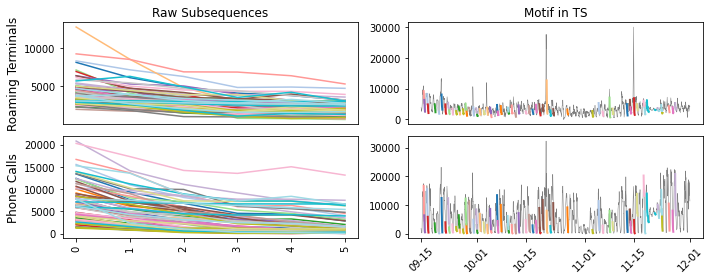

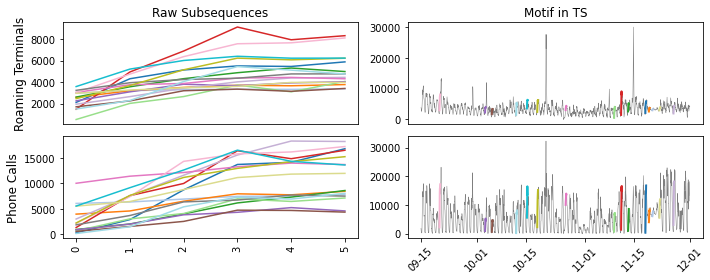

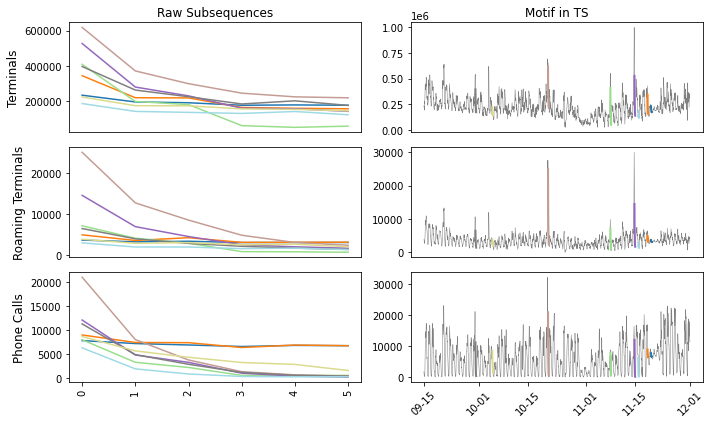

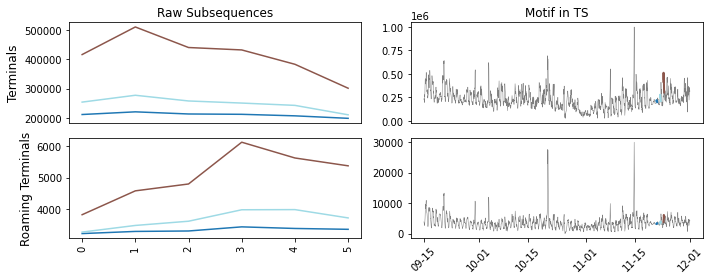

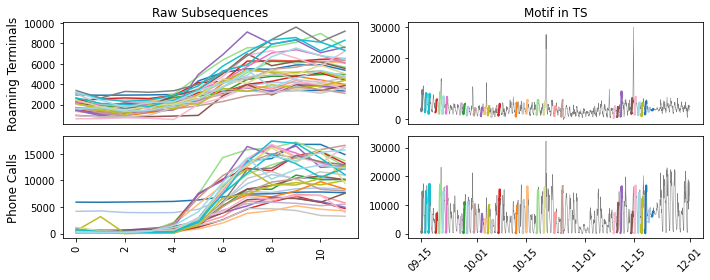

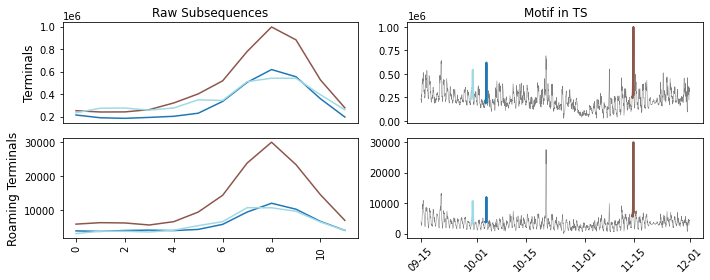

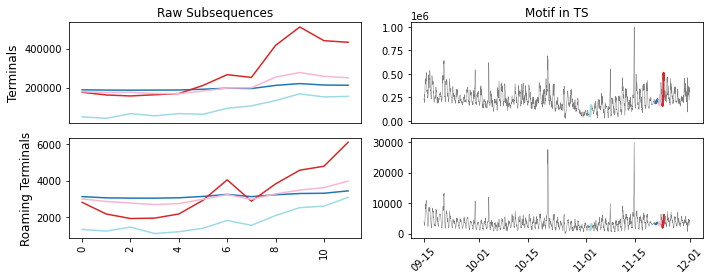

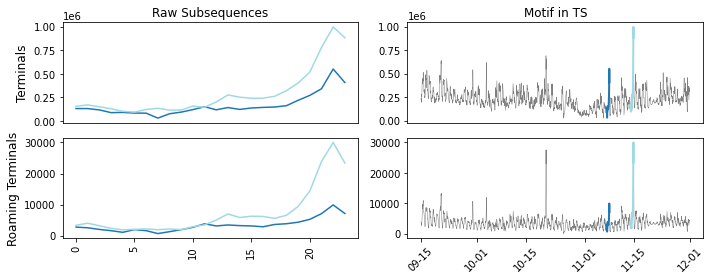

In [42]:
#plot top motif
for m in subsequence_lengths:
    print("Motif length: ", m)
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    top_motifs = top_motifs[top_motifs["k"] > 1].sort_values(by="p-value")
    for top_motif in top_motifs.to_dict(orient="records"): 
        m = top_motif["m"]
        dimensions = top_motif["Features"].split(",")
        dimensions = sorted([int(dimension) for dimension in dimensions])
        features = [data.columns[dimension] for dimension in dimensions]
        indices = top_motif['Indices'].replace("[","").replace("]","").split(",")
        indices = [int(i) for i in indices]
        motif_name = top_motif["ID"]
        ts_list = [data[feature] for feature in features]
        plot_motif(ts_list, features, m, indices, motif_name)